In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    roc_curve
)

from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, ttest_ind

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/Users/mohamedsabeer/Desktop/P2/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print(df.shape)
print(df.info())
print(df.isnull().sum())


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

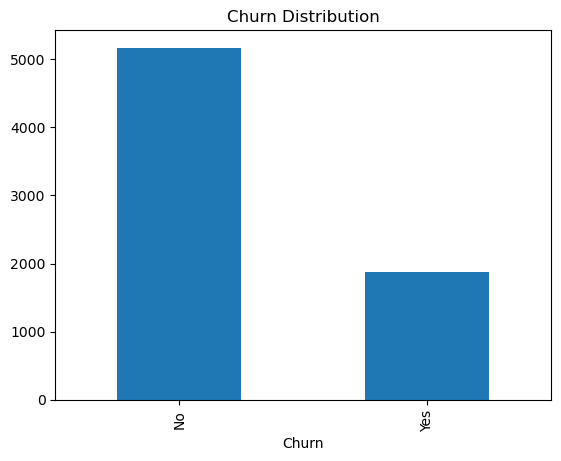

In [4]:
df["Churn"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.show()


In [5]:
print("===== Significant Churn Drivers =====")

for col in df.columns:
    if col == "Churn":
        continue

    if df[col].dtype == "object":

        table = pd.crosstab(df[col], df["Churn"])
        chi2, p, _, _ = chi2_contingency(table)

        if p < 0.05:
            print(f"{col} affects churn (p={p:.4f})")

    else:
        yes = df[df["Churn"] == "Yes"][col]
        no = df[df["Churn"] == "No"][col]

        stat, p = ttest_ind(yes, no)

        if p < 0.05:
            print(f"{col} affects churn (p={p:.4f})")


===== Significant Churn Drivers =====
SeniorCitizen affects churn (p=0.0000)
Partner affects churn (p=0.0000)
Dependents affects churn (p=0.0000)
tenure affects churn (p=0.0000)
MultipleLines affects churn (p=0.0035)
InternetService affects churn (p=0.0000)
OnlineSecurity affects churn (p=0.0000)
OnlineBackup affects churn (p=0.0000)
DeviceProtection affects churn (p=0.0000)
TechSupport affects churn (p=0.0000)
StreamingTV affects churn (p=0.0000)
StreamingMovies affects churn (p=0.0000)
Contract affects churn (p=0.0000)
PaperlessBilling affects churn (p=0.0000)
PaymentMethod affects churn (p=0.0000)
MonthlyCharges affects churn (p=0.0000)


In [6]:
df = df.drop("customerID", axis=1, errors="ignore")

df.fillna(method="ffill", inplace=True)

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])


In [7]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train))


After SMOTE: [3880 3880]


In [8]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:,1]


In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_test)
knn_probs = knn.predict_proba(X_test)[:,1]


In [10]:
def evaluate(name, y_true, preds, probs):
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_true, preds))
    print("Precision:", precision_score(y_true, preds))
    print("Recall:", recall_score(y_true, preds))
    print("F1:", f1_score(y_true, preds))
    print("ROC-AUC:", roc_auc_score(y_true, probs))
    print(classification_report(y_true, preds))


In [11]:
evaluate("Logistic Regression", y_test, log_preds, log_probs)
evaluate("KNN", y_test, knn_preds, knn_probs)



===== Logistic Regression =====
Accuracy: 0.7450312322544009
Precision: 0.5127840909090909
Recall: 0.7730192719486081
F1: 0.6165670367207515
ROC-AUC: 0.8401103429102861
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1294
           1       0.51      0.77      0.62       467

    accuracy                           0.75      1761
   macro avg       0.71      0.75      0.71      1761
weighted avg       0.80      0.75      0.76      1761


===== KNN =====
Accuracy: 0.6751845542305508
Precision: 0.43064729194187584
Recall: 0.6980728051391863
F1: 0.5326797385620915
ROC-AUC: 0.7470602252531036
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      1294
           1       0.43      0.70      0.53       467

    accuracy                           0.68      1761
   macro avg       0.65      0.68      0.64      1761
weighted avg       0.75      0.68      0.69      1761



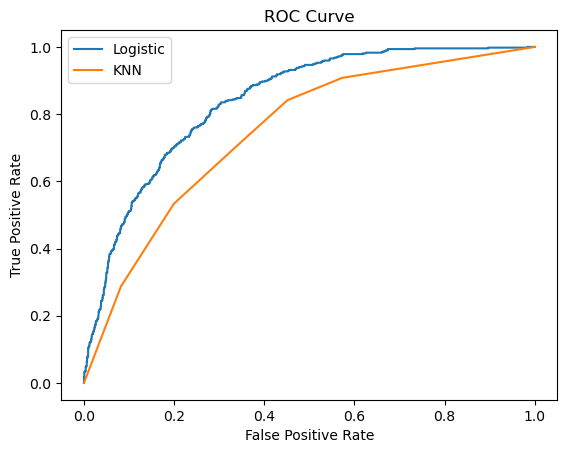

In [12]:
fpr1, tpr1, _ = roc_curve(y_test, log_probs)
fpr2, tpr2, _ = roc_curve(y_test, knn_probs)

plt.plot(fpr1, tpr1, label="Logistic")
plt.plot(fpr2, tpr2, label="KNN")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


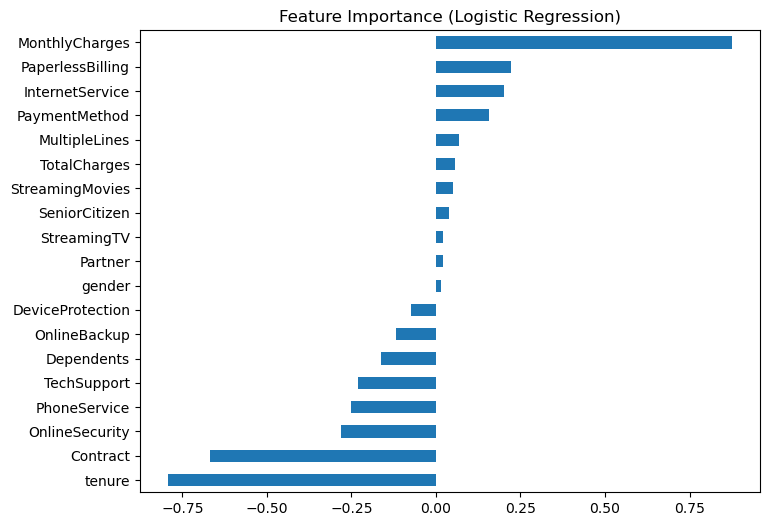

In [13]:
importance = pd.Series(log_model.coef_[0], index=df.drop("Churn", axis=1).columns)
importance.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (Logistic Regression)")
plt.show()
